In [10]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose
from hydra import initialize
from hydra.core.global_hydra import GlobalHydra

jupyter_black.load()
# plt.style.use("ggplot")
sns.set()


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [15]:
EXP_NAME = "exp090"
RUN_NAMES = ["run0", "run1", "run2", "run3", "run4"]
all_preds = []
all_keys = []
all_labels = []
for run_name in RUN_NAMES:
    RESULT_DIR = Path("../output/train") / EXP_NAME / run_name
    cfg = load_config(RESULT_DIR)
    preds = np.load(RESULT_DIR / "preds.npy")
    labels = np.load(RESULT_DIR / "labels.npy")
    keys = np.load(RESULT_DIR / "keys.npy")
    all_preds.append(preds)
    all_labels.append(labels)
    all_keys.append(keys)

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_keys = np.concatenate(all_keys)
gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").dropna().reset_index(drop=True)

/tmp/ipykernel_2397620/1028218295.py:23: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [14]:
import polars as pl

from src.utils.metrics import event_detection_ap
from src.utils.post_process import post_process_for_seg

In [38]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)
    # random_series_ids = ["f56824b503a0"]
    # random_series_ids = ["31011ade7c0a", "a596ad0b82aa"]  # nanはないがmiss labelのある期間がある
    # random_series_ids = ["05e1944c3818", "10469f6765bf"]

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 3 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
            pred = this_series_preds[0][:, [1, 2]]
            pred_df: pl.DataFrame = post_process_for_seg(
                [random_series_id] * len(pred),
                pred,
                score_th=cfg.post_process.score_th,
                distance=cfg.post_process.distance,
                low_pass_filter_hour=cfg.post_process.low_pass_filter_hour,
            )
            _gt_df = gt_df.query("series_id==@random_series_id")
            if len(_gt_df) == 0:
                score = 0.0
            else:
                score = event_detection_ap(_gt_df, pred_df.to_pandas())
        else:
            score = 0.0
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="gt_onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="gt_wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(-0.1, 1.1)
            axs[j].set_title(
                f"i={i} series_id: {random_series_id} chunk_id: {j} score: {score:.4f}"
            )
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

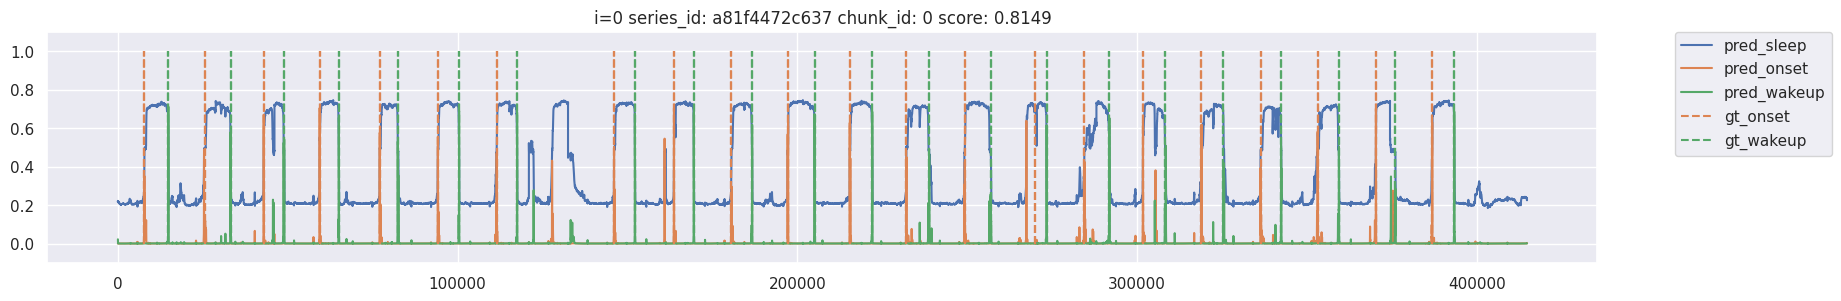

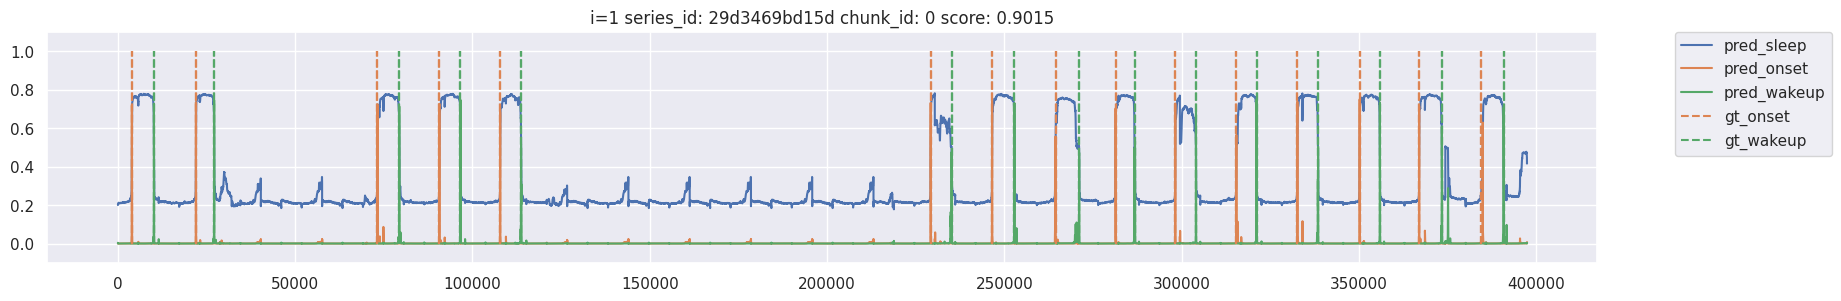

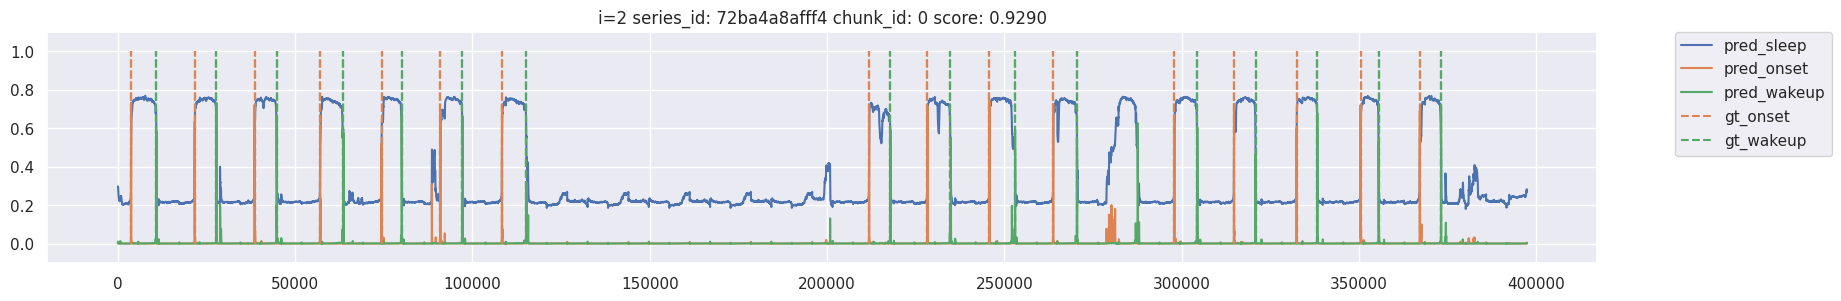

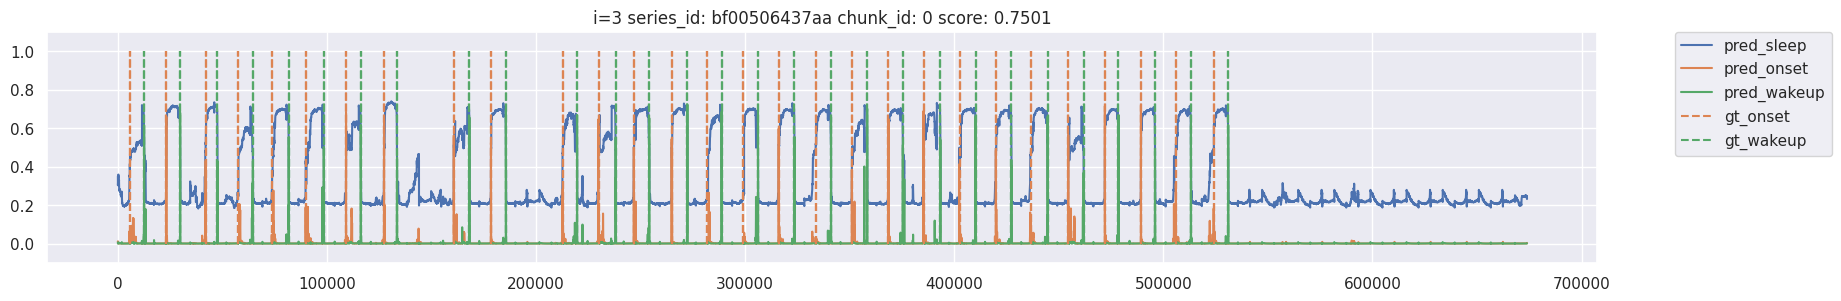

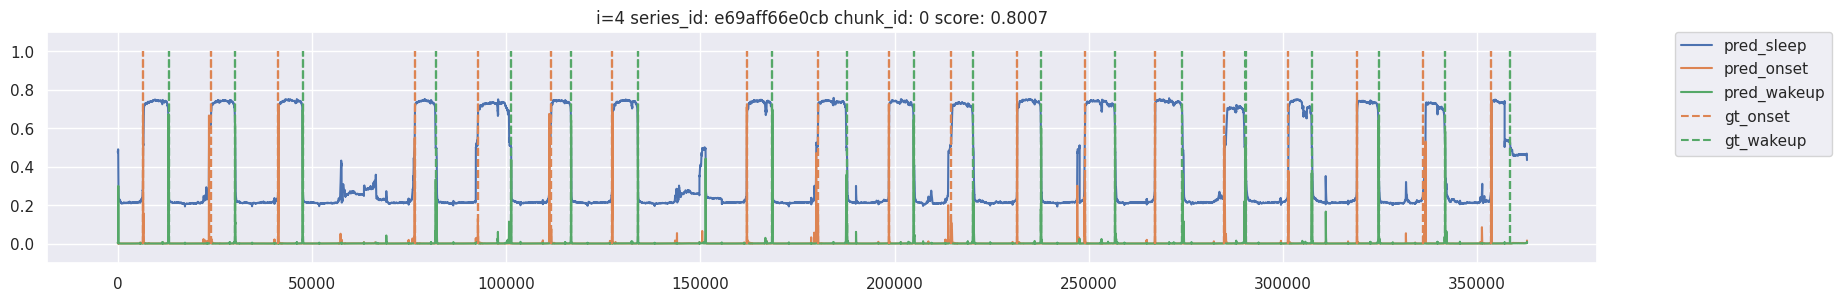

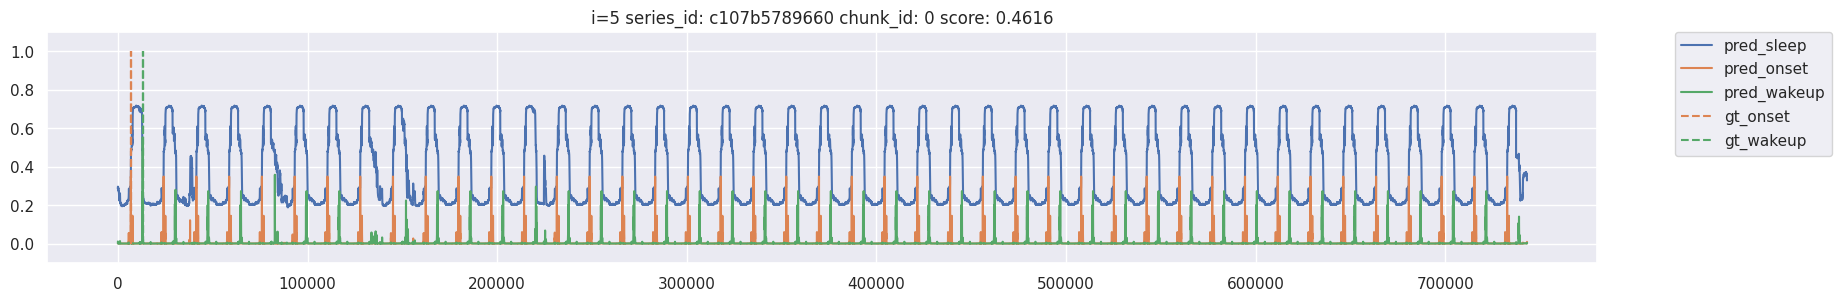

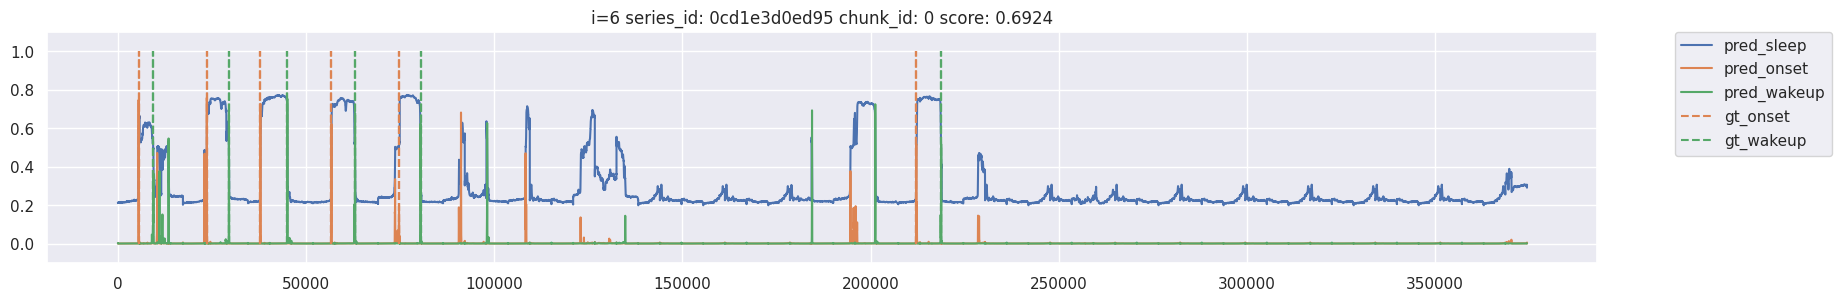

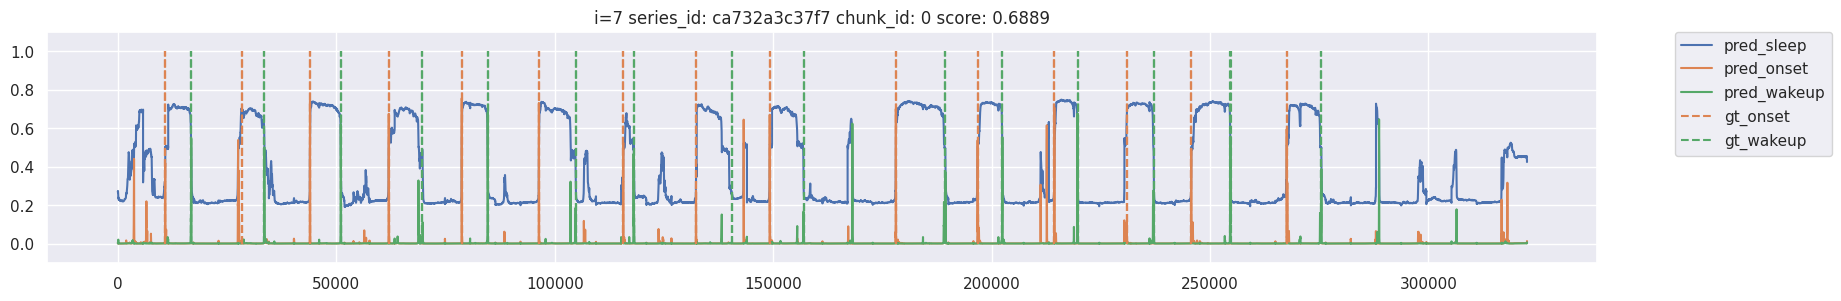

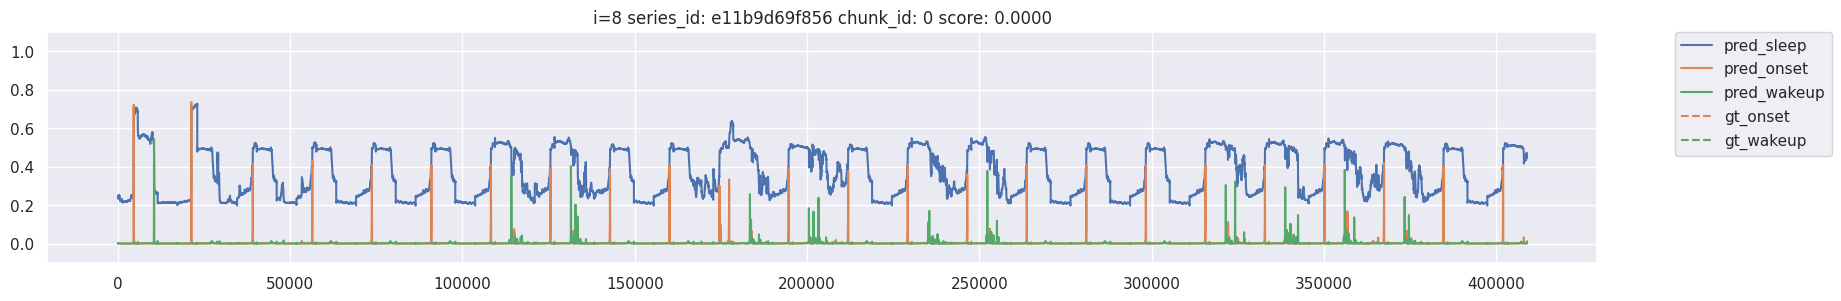

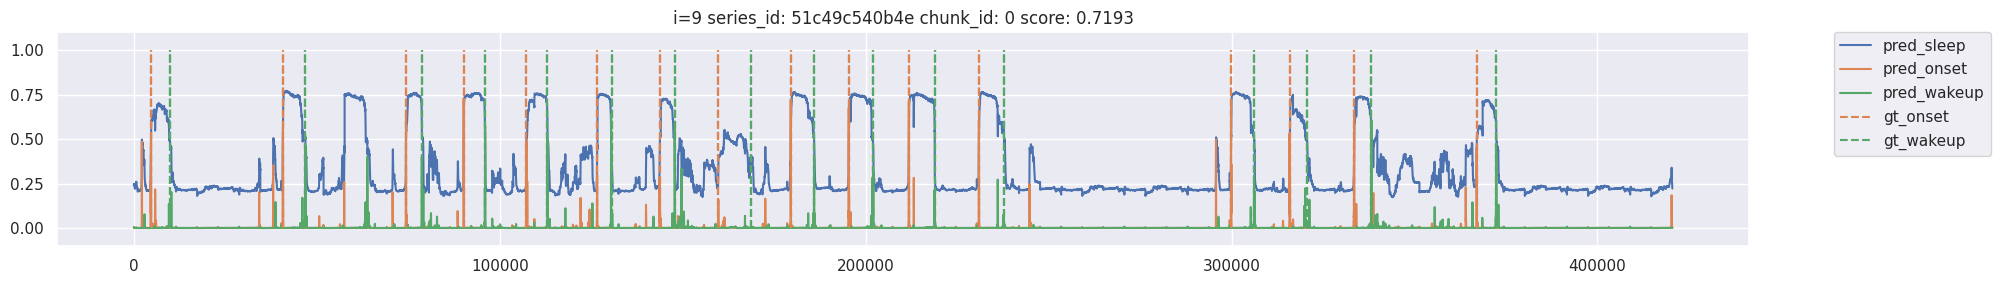

In [39]:
np.random.seed(0)
plot_random_sample(all_keys, all_preds, all_labels, num_samples=10, num_chunks=1)